## Plot compressed mutation prediction results

Here, we'll look at the results of our mutation prediction experiments with compressed (e.g. PCA projected) data. The idea is similar to `01_classify_stratified/plot_mutation_results.ipynb`, but with slightly more parameters (e.g. number of PCA components).

Notebook parameters:
* SIG_ALPHA (float): significance cutoff (after FDR correction)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# set results directory
results_dir = Path(cfg.results_dir, 'compressed_results', 'gene').resolve()
# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

In [3]:
# load raw data
results_df = au.load_compressed_prediction_results(results_dir, 'gene')
print(results_df.shape)
results_df.head()

(20988, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,0.69847,0.126440,MAP3K1,me_450k,shuffled,42,train,0,1000,gene
1,0.60472,0.112250,MAP3K1,me_450k,shuffled,42,test,0,1000,gene
2,0.59254,0.093408,MAP3K1,me_450k,shuffled,42,cv,0,1000,gene
3,0.92095,0.454370,MAP3K1,me_450k,shuffled,42,train,1,1000,gene
4,0.53710,0.082582,MAP3K1,me_450k,shuffled,42,test,1,1000,gene


In [4]:
# get dataframes comparing each data type to their shuffled baseline
compare_df = pd.DataFrame()
for n_dims in results_df.n_dims.unique():
    for training_data_type in results_df.training_data.unique():
        data_df = results_df[
            (results_df.training_data == training_data_type) &
            (results_df.n_dims == n_dims)
        ]
        # TODO: do we want to do this correction separately for each n_dims
        # and training data type? that's what this currently does
        data_results_df = au.compare_results(data_df,
                                             identifier='identifier',
                                             metric='aupr',
                                             correction=True,
                                             correction_method='fdr_bh',
                                             correction_alpha=SIG_ALPHA,
                                             verbose=False)
        data_results_df['training_data'] = training_data_type
        data_results_df['n_dims'] = n_dims
        compare_df = pd.concat((compare_df, data_results_df))
compare_df.head()

,identifier,delta_mean,p_value,corr_pval,reject_null,training_data,n_dims
0,ABL1,0.016164,4.588928e-01,5.631339e-01,False,me_450k,1000
1,ACVR1B,0.033155,4.644403e-01,5.631339e-01,False,me_450k,1000
2,ALK,-0.024539,2.712313e-01,3.869034e-01,False,me_450k,1000
3,APC,0.569697,1.098015e-08,4.015474e-07,True,me_450k,1000
4,AR,0.040342,2.198208e-01,3.230700e-01,False,me_450k,1000


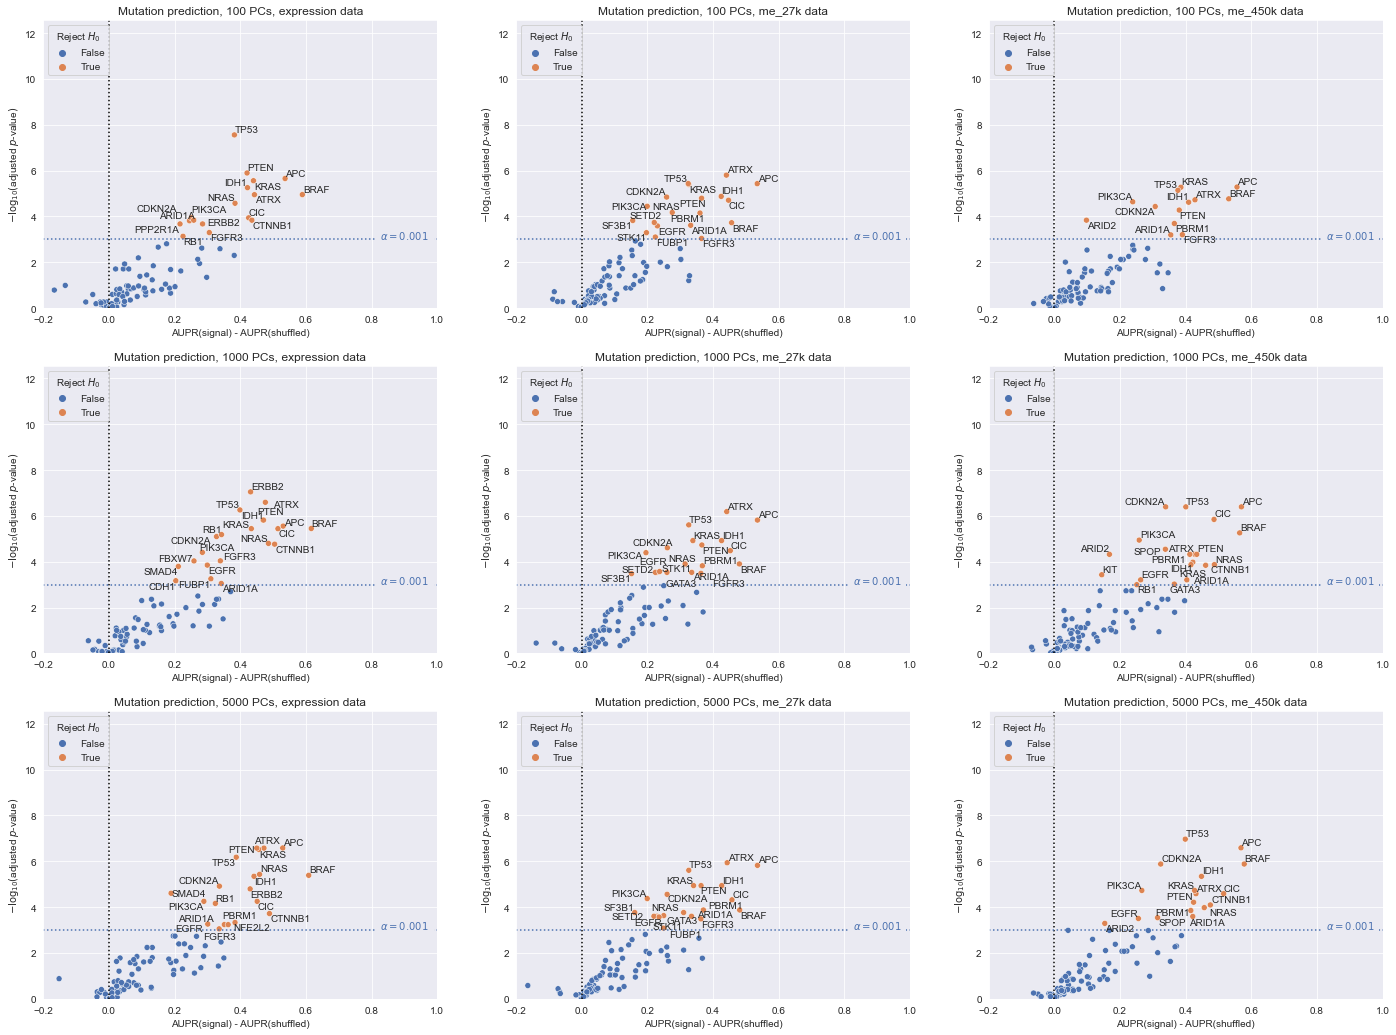

In [5]:
def label_points(x, y, gene, sig, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene, 'sig': sig})
    for i, point in a.iterrows():
        if point['y'] > -np.log10(SIG_ALPHA):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

compare_df = (
    compare_df.rename(columns={'identifier': 'gene'})
              .sort_values(by=['n_dims', 'training_data'])
)
compare_df['nlog10_p'] = -np.log10(compare_df.corr_pval)

sns.set({'figure.figsize': (24, 18)})
fig, axarr = plt.subplots(3, 3)

# plot mutation prediction from various data types, in a volcano-like plot
for row_ix, n_dims in enumerate(compare_df.n_dims.unique()):
    for col_ix, training_data_type in enumerate(compare_df.training_data.unique()):
        ax = axarr[row_ix, col_ix]
        data_df = compare_df[
            (compare_df.training_data == training_data_type) &
            (compare_df.n_dims == n_dims)
        ]
        sns.scatterplot(data=data_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                        hue_order=[False, True], ax=ax)
        # add vertical line at 0
        ax.axvline(x=0, linestyle=':', color='black')
        # add horizontal line at statistical significance threshold
        l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle=':')
        # label horizontal line with significance threshold
        # (matplotlib makes this fairly difficult, sadly)
        ax.text(0.9, -np.log10(SIG_ALPHA)+0.2,
                       r'$\alpha = {}$'.format(SIG_ALPHA),
                       va='center', ha='center', color=l.get_color(),
                       backgroundcolor=ax.get_facecolor())
        ax.set_xlabel('AUPR(signal) - AUPR(shuffled)')
        ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
        ax.set_xlim((-0.2, 1.0))
        y_max = max(compare_df.nlog10_p)
        ax.set_ylim((0, y_max+5))
        ax.legend(title=r'Reject $H_0$', loc='upper left')
        ax.set_title(r'Mutation prediction, {} PCs, {} data'.format(
            n_dims, training_data_type))

        # label genes and adjust text to not overlap
        # automatic alignment isn't perfect, can align by hand in inkscape if necessary
        text_labels = label_points(data_df['delta_mean'],
                                   data_df['nlog10_p'],
                                   data_df.gene,
                                   data_df.reject_null,
                                   ax)
        adjust_text(text_labels,
                    ax=ax, 
                    expand_text=(1., 1.),
                    lim=5)

(0.0, 0.45029250000000004)

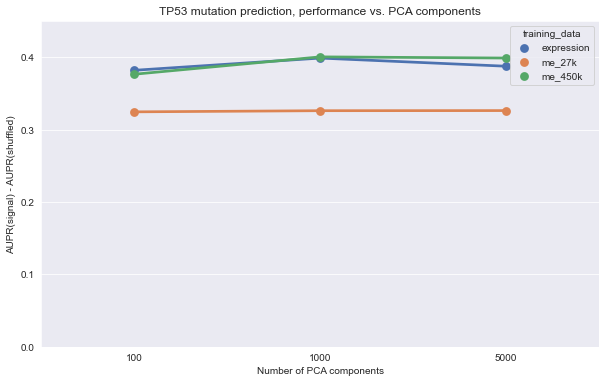

In [6]:
# line plot of performance over increasing number of PCs
# plot dotted line for expression/me performance with all genes?
gene = 'TP53'
sns.set({'figure.figsize': (10, 6)})
gene_df = compare_df[compare_df.gene == gene]
sns.pointplot(data=gene_df, x='n_dims', y='delta_mean', hue='training_data')
plt.title('{} mutation prediction, performance vs. PCA components'.format(gene))
plt.xlabel('Number of PCA components')
plt.ylabel('AUPR(signal) - AUPR(shuffled)')
plt.ylim(0, max(gene_df.delta_mean + 0.05))

100 expression me_27k
100 expression me_450k
100 me_27k me_450k
1000 expression me_27k
1000 expression me_450k
1000 me_27k me_450k
5000 expression me_27k
5000 expression me_450k
5000 me_27k me_450k


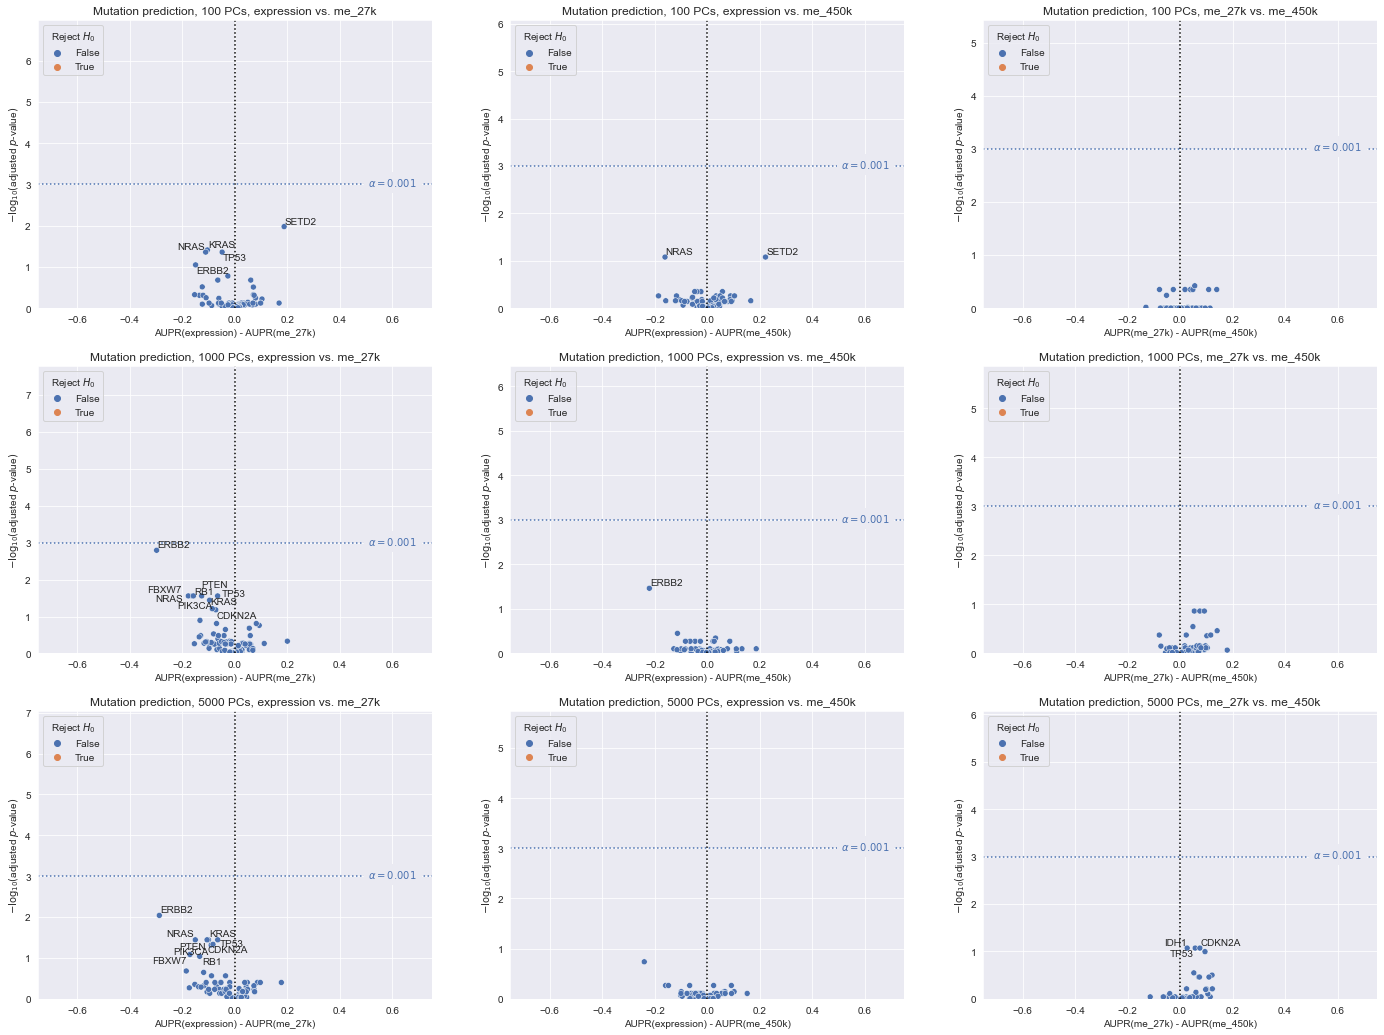

In [7]:
def label_points(x, y, gene, sig, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene, 'sig': sig})
    for i, point in a.iterrows():
        if point['y'] > 1.0:
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

# plot comparisons for all pairwise combinations of training datasets,
# within each choice of compression dimension
import itertools as it

sns.set({'figure.figsize': (24, 18)})
fig, axarr = plt.subplots(3, 3)

results_df.sort_values(by=['n_dims', 'training_data'], inplace=True)
for row_ix, n_dims in enumerate(results_df.n_dims.unique()):
    for col_ix, (train_1, train_2) in enumerate(
            it.combinations(results_df.training_data.unique(), 2)):
        print(n_dims, train_1, train_2)
        
        train_1_df = results_df[
            (results_df.n_dims == n_dims) &
            (results_df.training_data == train_1)
        ]
        train_2_df = results_df[
            (results_df.n_dims == n_dims) &
            (results_df.training_data == train_2)
        ]
        compare_df = au.compare_results(train_1_df,
                                        train_2_df,
                                        identifier='identifier',
                                        metric='aupr',
                                        correction=True,
                                        correction_method='fdr_bh',
                                        correction_alpha=SIG_ALPHA,
                                        verbose=False)
        compare_df.rename(columns={'identifier': 'gene'}, inplace=True)
        compare_df['nlog10_p'] = -np.log10(compare_df.corr_pval)
        
        ax = axarr[row_ix, col_ix]
        sns.scatterplot(data=compare_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                        hue_order=[False, True], ax=ax)
        # add vertical line at 0
        ax.axvline(x=0, linestyle=':', color='black')
        # add horizontal line at statistical significance threshold
        l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle=':')
        # label horizontal line with significance threshold
        # (matplotlib makes this fairly difficult, sadly)
        ax.text(0.6, -np.log10(SIG_ALPHA)+0.05,
                r'$\alpha = {}$'.format(SIG_ALPHA),
                va='center', ha='center', color=l.get_color(),
                backgroundcolor=ax.get_facecolor())
        ax.set_xlabel('AUPR({}) - AUPR({})'.format(train_1, train_2))
        ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
        ax.set_xlim((-0.75, 0.75))
        y_max = max(compare_df.nlog10_p)
        ax.set_ylim((0, y_max+5))
        ax.legend(title=r'Reject $H_0$', loc='upper left')
        ax.set_title(r'Mutation prediction, {} PCs, {} vs. {}'.format(
            n_dims, train_1, train_2))

        # label genes and adjust text to not overlap
        # automatic alignment isn't perfect, can align by hand in inkscape if necessary
        text_labels = label_points(compare_df['delta_mean'],
                                   compare_df['nlog10_p'],
                                   compare_df.gene,
                                   compare_df.reject_null,
                                   ax)
        adjust_text(text_labels,
                    ax=ax, 
                    expand_text=(1., 1.),
                    lim=5)